In [1]:
import matplotlib.pyplot as plt
import scanpy.external as sce
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import collections
import matplotlib
#import networkx
#import pyscenic
#import network
#import fsspec
#import igraph
import anndata
import scvi
import desc 
import umap
import h5py
import os
import re


#%load_ext rpy2.ipython
%matplotlib inline 


sc.settings.verbosity = 3     


# Setting the seed to 42
np.random.seed(42)


# Setting the default figure size parameters
sc.set_figure_params(figsize=(2, 2), format = 'svg', dpi_save = 300)
plt.rcParams.update({'font.size': 9})

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-os_data-OS742-OS742.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


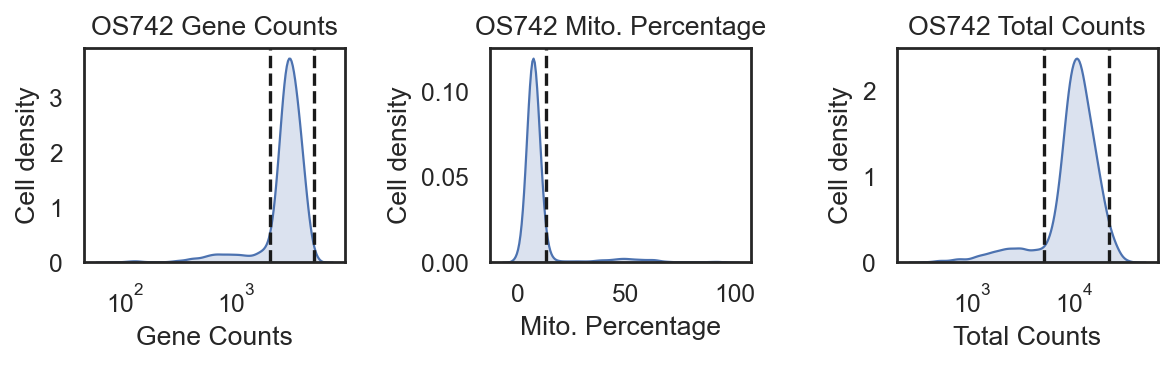

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:610: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


Filtered out 52549 genes that are detected 20 counts (shared).


In [2]:
# Reading in OS742 loom file
adata = scv.read('/Users/brendamelano/Desktop/os_data/OS742/OS742.loom', cache = True)


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Data for the variables
variables = [
    ('n_genes_by_counts', [(5000, '--'), (2000, '--')]),
    ('pct_counts_mt', [(13, '--')]),
    ('total_counts', [(5000, '--'), (22000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
        
    ax.set_title(f"OS742 {titles[var]}")  
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")

    
# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS742_filtering_plain.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 5000) &
                        (adata.obs['total_counts'] <= 22000) &
                        (adata.obs['n_genes_by_counts'] >= 2000) &
                        (adata.obs['n_genes_by_counts'] < 5000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 13)
                        ]


# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


Normalized count data: X, spliced, unspliced.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_88761/3875947729.py:11: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Us

    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    816 total control genes are used. (0:00:00)
computing score 'G2M_score'


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'G2M_score', score of gene set (adata.obs).
    766 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/

    finished (0:00:11)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


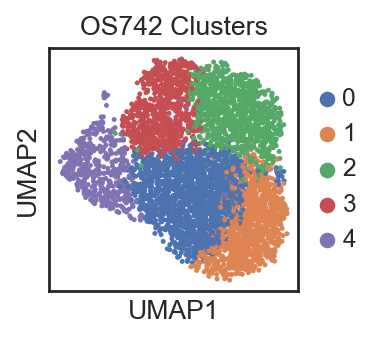

In [3]:


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
#scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)


# Log scaling
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# Freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)



# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, # try 2000
    subset=True,
    layer="counts"
)


genes = adata.var.index.values


# Reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Creating a variable for the cell cycle genes
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


# Scoring cells for cell cycle
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference scores
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)


#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


# Filtering the dataset for the most variable genes
adata = adata[:, adata.var.highly_variable]


# Regressing out total count, mitochondrial percentage and ccdifference scores
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


# 
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.47)

# Plotting the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS742 Clusters",
    size=20,
    show=False  # Do not display the plot immediately
)


# Save the plot as an SVG file
plt.savefig("/Users/brendamelano/Desktop/OS742_clusters.svg", format='svg')
plt.show()  

In [4]:

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_adata_leiden_PCA.h5ad")


# Reading in the state-labeled adata object

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


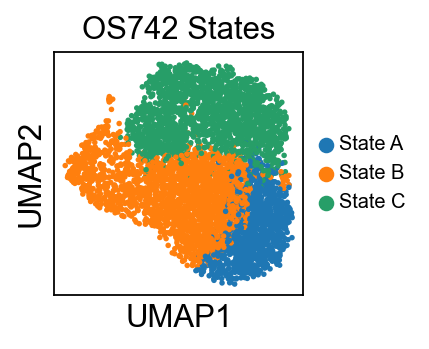

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/742_adata_PCA_subtypes.h5ad")


# Plotting based on UMAP
sc.pl.umap(adata, 
           color=['State'], 
           legend_fontsize=9, 
           title="OS742 States",
           show=False)  # Prevent the figure from displaying immediately


# Save the figure manually to Desktop
plt.savefig('/Users/brendamelano/Desktop/UMAP_OS742_State.svg', format='svg', dpi=300)

# Reading in leiden labeled data

In [6]:
adata = sc.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_adata_leiden_PCA.h5ad")


# Preparing h5 and rds files for mave

In [3]:
adata.write_h5ad('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/OS742_raw_filtered_feauture_bc_matrix.h5')


file_path = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/OS742_raw_filtered_feauture_bc_matrix.h5'

# Read the AnnData object
adata = sc.read_h5ad(file_path)

# Check the contents of the AnnData object
print(adata)            
print(adata.obs.head()) # Shows metadata associated with cells
print(adata.var.head()) # Shows metadata associated with genes
print(adata.X[:5])  


AnnData object with n_obs × n_vars = 4824 × 8992
    obs: 'Clusters', '_X', '_Y', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
                         Clusters         _X         _Y  n_genes_by_counts  \
CellID                                                                       
OS742:AACACACCACCCTAGGx         4 -23.931486 -29.385838               3747   
OS742:AACCATGAGACGCCAAx         0 -16.288481  -5.394587               3028   
OS742:AACAGGGAGCGGCTCTx         2  30.737591   1.549309               3439   
OS742:AAAGGGCGTAGGTTTCx         5  16.144836   9.557175               2328   
OS742:AACAGGGCAAAGTATGx         3  -4.209813  -2.217078               3521   

                         total_

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate automatic pandas to R DataFrame conversion
pandas2ri.activate()

# Define the file path to your h5ad file
file_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/OS742_raw_filtered_feauture_bc_matrix.h5"

# Read the AnnData object
adata = sc.read_h5ad(file_path)

# Extract the count matrix, cell barcodes, and gene names
count_matrix = adata.X
cell_barcodes = adata.obs_names
gene_names = adata.var_names

from scipy.io import mmwrite

# Save the count matrix in Matrix Market format
mmwrite('/Users/brendamelano/Desktop/OS742_count_matrix.mtx', count_matrix)

# Save cell barcodes and gene names
cell_barcodes.to_series().to_csv('/Users/brendamelano/Desktop/OS742_barcodes.tsv', sep='\t', index=False, header=False)
gene_names.to_series().to_csv('/Users/brendamelano/Desktop/OS742_genes.tsv', sep='\t', index=False, header=False)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


# Marker identification

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)
cluster_markers

Subtype_A_genes_742 = cluster_markers.iloc[:, 0].tolist()


# Extract gene names and log fold changes into a DataFrame
gene_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logfc_df = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])

# Filter for logFC > 1. This involves checking each gene's logFC across all clusters
# and selecting the gene if it has logFC > 1 in any of the clusters.
filtered_genes = gene_names_df[logfc_df > 1].stack().reset_index(level=1, drop=True).unique()

top_genes_by_cluster = {}  # Dictionary to hold top genes for each cluster

# Assuming gene_names_df and logfc_df have been correctly defined as before
num_clusters = gene_names_df.shape[1]

for cluster_idx in range(num_clusters):
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    top_genes_by_cluster[f"Cluster {cluster_idx}"] = top_genes
    
sc.pl.matrixplot(
    adata,
    top_genes_by_cluster,
    "leiden",
    #dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_A_markers.csv", Subtype_A_genes_742, delimiter=",", fmt='%s')


<Figure size 1200x300 with 0 Axes>

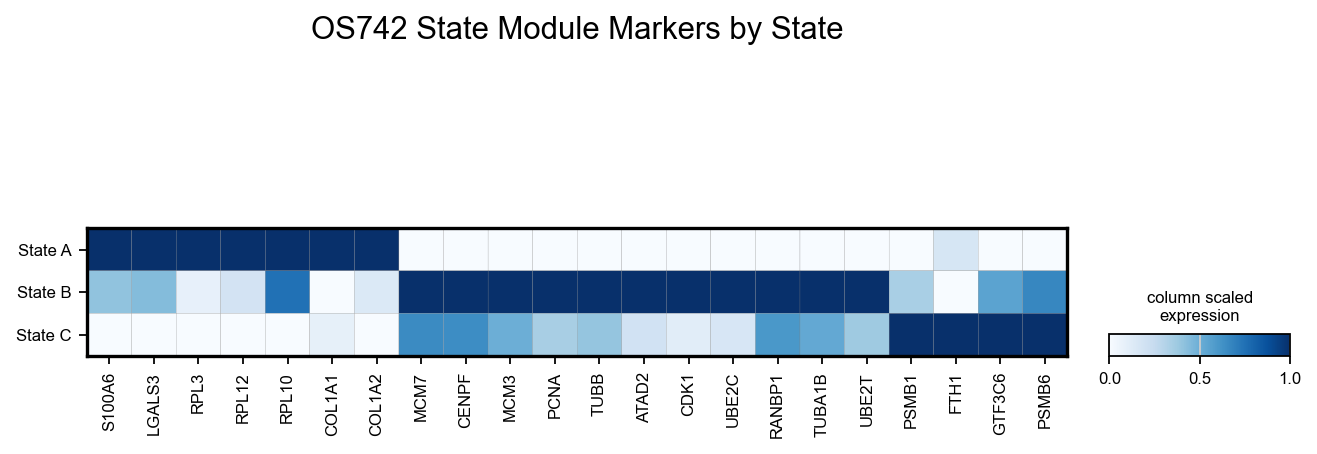

In [7]:

# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


# Plotting the matrix plot
ax = sc.pl.matrixplot(
    adata,
    var_names=combined_genes,  # Use the sorted list of genes
    groupby='State',
    cmap="Blues",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS742 State Module Markers by State",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/O742_subtype_markers.svg", format='svg')

plt.show()

plt.close()

# Cluster marker heatmap

/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_58183/3518678348.py:42: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


<Figure size 1200x300 with 0 Axes>

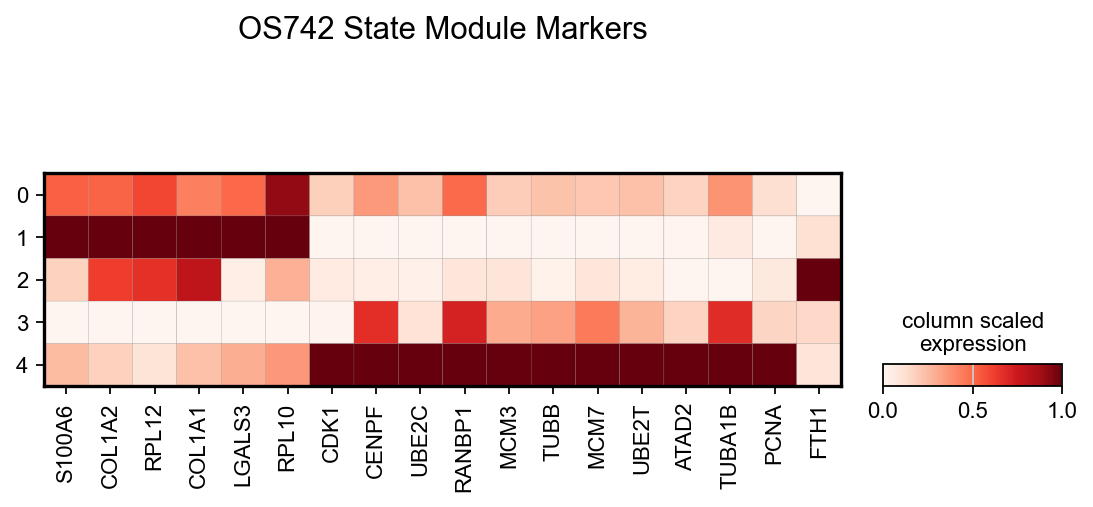

In [7]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes

# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')




plt.rcParams.update({'font.size': 12})

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes))


# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in Subtype_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['State'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS742 State Module Markers",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS742_cluster_markers.svg", format='svg')

plt.show()

plt.close()


In [3]:
Subtype_A_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv', header=0)


Subtype_A_genes = Subtype_A_genes.to_numpy()



# Convert the set of tuples back to a list of lists (if necessary)
Subtype_A_genes = [list(gene) for gene in Subtype_A_genes]


Subtype_A_genes = np.array(Subtype_A_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_A_genes_df = pd.DataFrame(Subtype_A_genes, columns=['Gene'])

Subtype_A_genes = Subtype_A_genes_df['Gene']

Subtype_B_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv', header=0)


Subtype_B_genes = Subtype_B_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_B_genes = [list(gene) for gene in Subtype_B_genes]


Subtype_B_genes = np.array(Subtype_B_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_B_genes_df = pd.DataFrame(Subtype_B_genes, columns=['Gene'])

Subtype_B_genes = Subtype_B_genes_df['Gene']

Subtype_C_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv', header=0)


Subtype_C_genes = Subtype_C_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_C_genes = [list(gene) for gene in Subtype_C_genes]


Subtype_C_genes = np.array(Subtype_C_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_C_genes_df = pd.DataFrame(Subtype_C_genes, columns=['Gene'])

Subtype_C_genes = Subtype_C_genes_df['Gene']

In [4]:

# Function to process gene files through the pipeline
def process_genes(file_path):
    # Read file into a DataFrame
    genes = pd.read_csv(file_path, header=0)

    # Convert DataFrame to numpy array
    genes_array = genes.to_numpy()

    # Step 4: Convert set of tuples back to a list of lists
    genes_list = [list(gene) for gene in genes_array]

    # Step 5: Flatten the list of lists into a numpy array
    genes_flattened = np.array(genes_list).flatten()

    # Step 6: Convert numpy array to a pandas DataFrame
    genes_df = pd.DataFrame(genes_flattened, columns=['Gene'])

    return genes_df

# File paths for gene modules
file_paths = {
    "A": '/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv',
    "B": '/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv',
    "C": '/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv',
}



# Process each subtype and store results
processed_genes = {}
for key, path in file_paths.items():
    if os.path.exists(path):
        processed_genes[key] = process_genes(path)
    else:
        print(f"Skipping Subtype {key} due to missing file.")

# Output processed gene data for each subtype
for key, df in processed_genes.items():
    print(f"\nProcessed genes for Subtype {key}:")
    print(df)
    
    
# Concatenate all DataFrames into a single DataFrame
combined_genes_df = pd.concat(processed_genes.values(), ignore_index=True)

# View the combined DataFrame
print("\nCombined genes DataFrame:")
print(combined_genes_df)


Processed genes for Subtype A:
     Gene
0  S100A6
1  LGALS3
2    RPL3
3   RPL12
4   RPL10
5  COL1A1
6  COL1A2

Processed genes for Subtype B:
      Gene
0     MCM7
1    CENPF
2     MCM3
3     PCNA
4     TUBB
5    ATAD2
6     CDK1
7    UBE2C
8   RANBP1
9   TUBA1B
10   UBE2T

Processed genes for Subtype C:
     Gene
0   PSMB1
1    FTH1
2  GTF3C6
3   PSMB6

Combined genes DataFrame:
      Gene
0   S100A6
1   LGALS3
2     RPL3
3    RPL12
4    RPL10
5   COL1A1
6   COL1A2
7     MCM7
8    CENPF
9     MCM3
10    PCNA
11    TUBB
12   ATAD2
13    CDK1
14   UBE2C
15  RANBP1
16  TUBA1B
17   UBE2T
18   PSMB1
19    FTH1
20  GTF3C6
21   PSMB6


In [5]:
# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes_df['Gene'] if gene in adata.raw.var_names]


<Figure size 6000x3000 with 0 Axes>

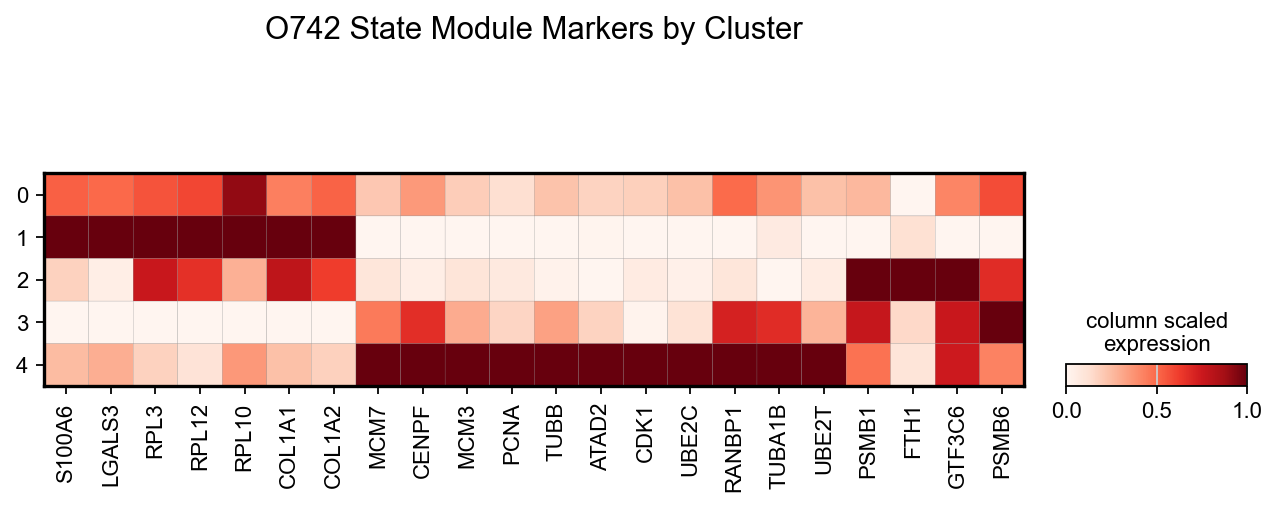

In [11]:

# Create a figure explicitly
plt.figure(figsize=(10, 5), dpi=600) 


ax = sc.pl.matrixplot(
    adata,
    var_names=combined_genes_df['Gene'],  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="O742 State Module Markers by Cluster",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS742_cluster_markers.svg", format='svg')

plt.show()

plt.close()


# State level pathway heatmap

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    197 total control genes are used. 

    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'
    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_s

    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_35089/3849509079.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha='right')


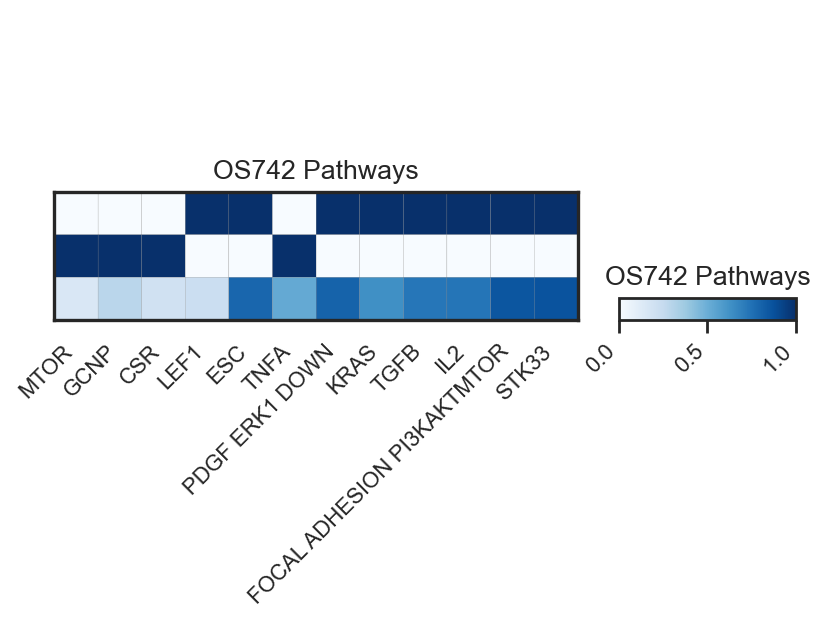

In [8]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

# Defining the score names
scores = ['MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score', 'ESC_genes_score', 'TNFA_genes_score',
          'PDGF_ERK1_DOWN_genes_score', 'KRAS_genes_score', 'TGFB_genes_score',
          'IL2_genes_score', 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score']

# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "State",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)

# Modify the x-axis and y-axis labels
for ax in axes_dict.values():
    labels = [label.get_text().replace('_genes_score', '').replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(['' for _ in ax.get_yticklabels()])  # Remove y-axis labels
    ax.set_title('OS742 Pathways', fontsize=12)

# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS742_Pathways.svg', format='svg')  # Adjust path as needed

# Show the plot if desired
plt.show()

# Subtype Module enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    594 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


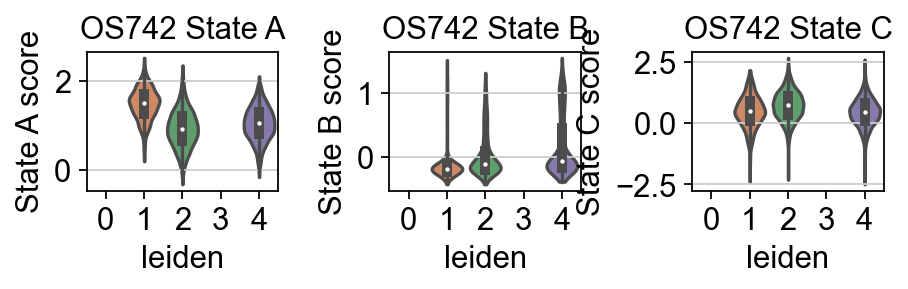

In [3]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)
axs[0].set_title('OS742 State A')

sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)
axs[1].set_title('OS742 State B')

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('OS742 State C')

plt.tight_layout()

# Saving the fig onto the desktop
#plt.savefig('/Users/brendamelano/Desktop/OS742_gsea_scores.svg', format='svg')

plt.show()

# Subtype B module identification

In [ ]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '3'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)



In [5]:
OS742_subtype_B_markers = OS742_subtype_B_markers.iloc[:, 0].tolist()


#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_B_markers.csv", OS742_subtype_B_markers, delimiter=",", fmt='%s')


['CDK1',
 'CLSPN',
 'UBE2C',
 'MCM10',
 'MKI67',
 'TOP2A',
 'NDC80',
 'HMGB2',
 'GTSE1',
 'RAD51AP1',
 'CDC45',
 'NCAPG',
 'AURKB',
 'KIF23',
 'ATAD2',
 'AURKA',
 'CCNA2',
 'ASPM',
 'DSCC1',
 'PCNA',
 'MYBL2',
 'HMMR',
 'TYMS',
 'UBE2T',
 'DLGAP5',
 'MCM7',
 'ORC6',
 'CENPF',
 'MCM5',
 'MCM3',
 'WDHD1',
 'TK1',
 'TUBB4B',
 'PRIM1',
 'BIRC5',
 'GMNN',
 'ZWINT',
 'USP1',
 'TPX2',
 'CDKN3',
 'SMC4',
 'CENPM',
 'RFC4',
 'KPNA2',
 'H2AX',
 'TUBA1B',
 'CKS2',
 'MAD2L1',
 'TUBG1',
 'TMPO',
 'RRM1',
 'TUBB',
 'DEK',
 'DUT',
 'DNMT1',
 'CENPX',
 'TUBA1C',
 'RANBP1',
 'SMC3',
 'H2AZ1']

# Subtype C module identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '0'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS742_subtype_C_markers = OS742_subtype_C_markers.iloc[:, 0].tolist()

OS742_subtype_C_markers

np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_C_markers.csv", OS742_subtype_C_markers, delimiter=",", fmt='%s')


computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    251 total control genes are used. (0:00:00)


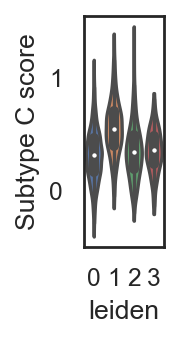

In [3]:
# reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')


# GSEA

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    197 total control genes are used. 

    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'
    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_s

    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_79288/1635586820.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha='right')


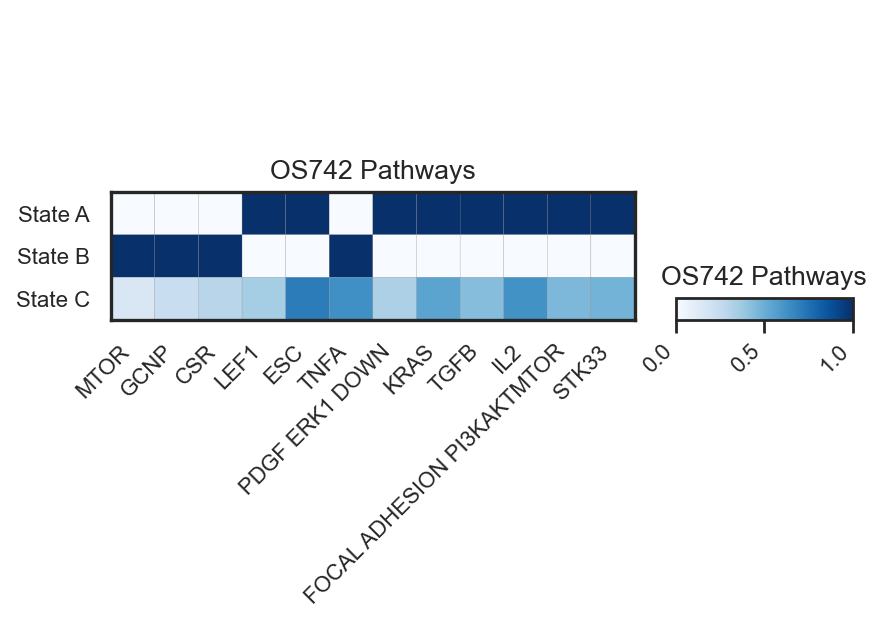

In [33]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

# Defining the score names
scores = ['MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score', 'ESC_genes_score', 'TNFA_genes_score',
          'PDGF_ERK1_DOWN_genes_score', 'KRAS_genes_score', 'TGFB_genes_score',
          'IL2_genes_score', 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score']

# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "State",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)

# Modify the x-axis labels
for ax in axes_dict.values():
    labels = [label.get_text().replace('_genes_score', '').replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title('OS742 Pathways', fontsize=12)

# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS742_Pathways.svg', format='svg')  # Adjust path as needed

# Show the plot if desired
plt.show()

In [5]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import kruskal

def plot_facet_gene_expression(adata, gene_list, output_file, cell_line, significance_threshold=0.05):
    """
    Quantify and visualize the expression of specified genes as a facet plot across different states.
    Applies FDR correction for multiple testing.

    Parameters:
    - adata: AnnData object containing single-cell data.
    - gene_list: List of gene names to quantify and plot.
    - output_file: Path to save the resulting facet plot.
    - cell_line: String specifying the cell line name to include in plot titles.
    - significance_threshold: FDR threshold for significance (default is 0.05).
    """
    # Filter genes to keep only those present in the dataset
    genes_in_data = [gene for gene in gene_list if gene in adata.var_names]
    genes_not_found = [gene for gene in gene_list if gene not in adata.var_names]

    if genes_not_found:
        print(f"The following genes were not found in the dataset and will be skipped: {', '.join(genes_not_found)}")
    
    if not genes_in_data:
        print("None of the specified genes are present in the dataset.")
        return

    # List to store p-values for correction
    p_values = []

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame()

    # Calculate mean expression and perform tests for each gene
    for gene in genes_in_data:
        # Extract the gene expression data
        gene_data = adata[:, gene].X.toarray().flatten()  # Get the gene expression vector

        # Create a DataFrame with state, gene name, and expression data
        gene_df = pd.DataFrame({
            'State': adata.obs['State'],
            'Expression': gene_data,
            'Gene': gene
        })

        # Append the gene-specific data to the main plot_df
        plot_df = pd.concat([plot_df, gene_df], axis=0)

        # Perform Kruskal-Wallis test (non-parametric alternative to ANOVA)
        _, p_value = kruskal(*[gene_df.loc[gene_df['State'] == state, 'Expression'] for state in gene_df['State'].unique()])
        p_values.append(p_value)

    # Step 2: Apply Benjamini-Hochberg (BH) correction
    _, corrected_pvals, _, _ = multipletests(p_values, alpha=significance_threshold, method='fdr_bh')

    # Step 3: Add corrected p-values to the DataFrame
    pval_dict = dict(zip(genes_in_data, corrected_pvals))
    plot_df['Corrected p-value'] = plot_df['Gene'].map(pval_dict)

    # Step 4: Create the facet plot
    g = sns.FacetGrid(plot_df, col='Gene', col_wrap=2, sharey=False, height=3, aspect=1.3)
    g.map(sns.barplot, 'State', 'Expression', palette='Set2', edgecolor='black')

    # Customize plot appearance
    for ax, gene in zip(g.axes.flat, genes_in_data):
        # Annotate each plot with the corrected p-value
        pval = pval_dict[gene]
        significance_label = "Significant" if pval < significance_threshold else "Not Significant"
        ax.text(0.95, 0.95, f'FDR p = {pval:.2e} ({significance_label})',
                horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        
        # Customize tick and label fonts
        ax.set_xlabel('')
        ax.set_ylabel(f'{gene} Expression', fontsize=9)
        ax.tick_params(axis='x', labelsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.set_title(f"{cell_line} - {gene}", fontsize=9)

    # Set overall plot labels and layout
    g.set_titles(col_template="{col_name}", fontsize=9)
    g.set_xlabels("State", fontsize=9)
    g.set_ylabels("Expression", fontsize=9)
    g.fig.suptitle(f"{cell_line} Gene Expression Across States", y=1.05, fontsize=12)
    g.fig.tight_layout()

    # Save the facet plot
    plt.savefig(output_file, format='svg', dpi=300)
    plt.close()
    print(f"Facet plot saved to {output_file}")

# Example Usage
# Path to save the output plot
output_file = '/Users/brendamelano/Desktop/OS742_drivers_expression_facet.svg'

# Specify the cell line name
cell_line = 'OS742'


# Gene list
gene_list = ['DDIT3', 'TSHZ2', 'STAT1', 'NR0B1', 'NFE2L3', 'TCF4', 'NFKB2', 'IRF1', 'ZIC2', 'KLF12', 'JUNB', 'JUN']


# Call the function to generate the facet plot
plot_facet_gene_expression(adata, gene_list, output_file, cell_line)

The following genes were not found in the dataset and will be skipped: TSHZ2, NR0B1, NFE2L3, NFKB2, IRF1, ZIC2, JUNB


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Facet plot saved to /Users/brendamelano/Desktop/OS742_drivers_expression_facet.svg


# RNA velocity

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/634 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

    finished (0:05:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/4824 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


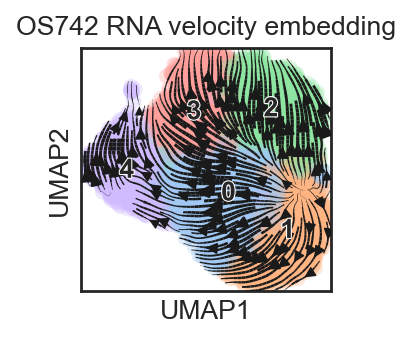

In [41]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]


# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 palette=colors, title = 'OS742 RNA velocity embedding',
                                frameon = True)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


saving figure to file ./figures/scvelo_OS742_velocity_embedding_stream.svg


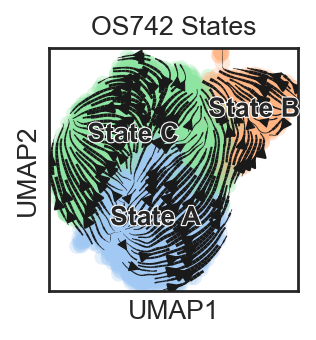

In [26]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='State', 
                                 rasterized=True,
                                 palette=colors, title = 'OS742 States',
                                 frameon = True,
                                 save='OS742_velocity_embedding_stream.svg')

# State labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


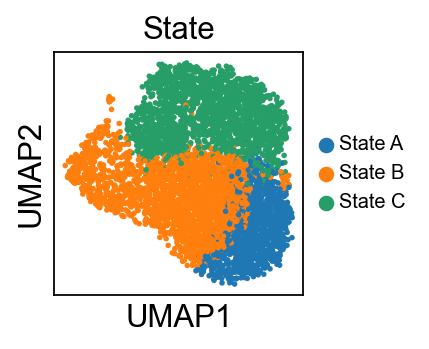

In [3]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')


# Combining cluster 1 and 3
adata.obs['leiden'][adata.obs['leiden']=='0']='4'
adata.obs['leiden'][adata.obs['leiden']=='3']='2'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'State C': ['2'], 'State B': ['4'], 'State A': ['1']}


# Initialize empty column in cell metadata
adata.obs['State'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'State'] = i

    
# Plotting umap based on subtype
sc.pl.umap(adata, color=['State'], legend_fontsize=9)


In [8]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/742_adata_PCA_subtypes.h5ad")



In [5]:
# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'State', method='wilcoxon')

# Creating a df for the cluster specific markers
state_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


In [6]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = 'State A'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS742_subtype_A_markers = OS742_subtype_A_markers.iloc[:, 0].tolist()

OS742_subtype_A_markers

np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_State_A_markers_NMF.csv", OS742_subtype_A_markers, delimiter=",", fmt='%s')


In [7]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = 'State B'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS742_subtype_B_markers = OS742_subtype_B_markers.iloc[:, 0].tolist()

OS742_subtype_B_markers

np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_State_B_markers_NMF.csv", OS742_subtype_B_markers, delimiter=",", fmt='%s')


In [9]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = 'State C'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS742_subtype_C_markers = OS742_subtype_C_markers.iloc[:, 0].tolist()

OS742_subtype_C_markers

np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_State_C_markers_NMF.csv", OS742_subtype_C_markers, delimiter=",", fmt='%s')


# Splitting in State-specific BAM files

In [3]:
from argparse import ArgumentParser
import numpy as np
import os
import pandas as pd
import pysam

In [4]:
# Defining the function to generate a tsv file with the states and associated 10X cell barcode
def generate_tsv_from_anndata(adata, tsv_output_path, meta_col="State"):
    # Use adata.obs.index for barcodes
    barcodes = adata.obs.index
    
    # Clean the barcodes to remove prefix and suffix and add '-1' suffix
    barcodes = barcodes.str.replace(r'^OS742:', '', regex=True).str.replace(r'x$', '', regex=True) + '-1'
    cell_types = adata.obs[meta_col]
    df = pd.DataFrame({'Barcode': barcodes, meta_col: cell_types})
    df.to_csv(tsv_output_path, sep='\t', index=False)
    print(f"TSV file saved to {tsv_output_path}")
    
    
# Defining the directory in which to save the tsv
tsv_output_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_10Xbarcode_state.tsv"
generate_tsv_from_anndata(adata, tsv_output_path)



TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_10Xbarcode_state.tsv


In [5]:


# Read the TSV file into a DataFrame
df = pd.read_csv(tsv_output_path, sep='\t')
df


def split_bam(bamobj, dict_cells):
    dict_barcodes = {}
    for celltype in dict_cells.keys():
        print(f"Extracting {celltype} barcodes")
        barcodes = dict_cells[celltype]["barcodes"]
        for barcode in barcodes:
            dict_barcodes[barcode] = celltype
    barcodes = np.array(list(dict_barcodes.keys()))
    numreads = 0
    numaddedreads = 0
    for read in bamobj:
        cellbarcode = "0"
        for k in range(len(read.tags)):
            if read.tags[k][0] == "CB":
                cellbarcode = read.tags[k][1]
        if cellbarcode != "0":
            barcode_exists = cellbarcode in barcodes
            good_qual = read.mapq > 10
            if barcode_exists and good_qual:
                celltype = dict_barcodes[cellbarcode]
                dict_cells[celltype]["bamobj"].write(read)
                numaddedreads += 1
        if numreads % 500000 == 0:
            print(f"{numreads} reads analyzed, {numaddedreads} added")
        numreads += 1

def main(bampath, outdir, barcodepath, meta_col, samplename):
    bamobj = pysam.AlignmentFile(bampath, "rb")
    metadf = pd.read_csv(barcodepath, sep="\t")
    metadf = metadf[metadf[meta_col] == samplename]
    adname = samplename.replace(" ", "_")
    outpath = os.path.join(outdir, f"{adname}.bam")
    adobj = pysam.AlignmentFile(outpath, "wb", template=bamobj)
    dict_cells = {
        samplename: {
            "barcodes": np.array(metadf["Barcode"]),
            "bampath": outpath,
            "bamobj": adobj}}
    split_bam(bamobj, dict_cells)
    for celltype in pd.unique(metadf[meta_col]):
        dict_cells[celltype]["bamobj"].close()
    bamobj.close()
    
BAMPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_possorted_genome_bam.bam" #"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/possorted_genome_bam.bam"
OUTDIR = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs"
BARCODEPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_10Xbarcode_subtype.tsv"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/OS152_10Xbarcode_subtype.tsv"
Subtypes = ["State A", "State B", "State C"]


for CELLTYPE in Subtypes:
    main(BAMPATH, OUTDIR, BARCODEPATH, "State", CELLTYPE)

TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/OS742_10Xbarcode_subtype.tsv
Extracting State A barcodes
0 reads analyzed, 0 added
500000 reads analyzed, 173273 added
1000000 reads analyzed, 384597 added
1500000 reads analyzed, 597073 added
2000000 reads analyzed, 817466 added
2500000 reads analyzed, 1042421 added
3000000 reads analyzed, 1252331 added
3500000 reads analyzed, 1460932 added
4000000 reads analyzed, 1680963 added
4500000 reads analyzed, 1890089 added
5000000 reads analyzed, 2117181 added
5500000 reads analyzed, 2328337 added
6000000 reads analyzed, 2533237 added
6500000 reads analyzed, 2720497 added
7000000 reads analyzed, 2932413 added
7500000 reads analyzed, 3152195 added
8000000 reads analyzed, 3350388 added
8500000 reads analyzed, 3503391 added
9000000 reads analyzed, 3727723 added
9500000 reads analyzed, 3974570 added
10000000 reads analyzed, 4218759 added
10500000 reads analyzed, 4442564 added
11000000 reads anal

101500000 reads analyzed, 44036728 added
102000000 reads analyzed, 44247755 added
102500000 reads analyzed, 44447582 added
103000000 reads analyzed, 44673897 added
103500000 reads analyzed, 44896871 added
104000000 reads analyzed, 45115683 added
104500000 reads analyzed, 45348048 added
105000000 reads analyzed, 45582176 added
105500000 reads analyzed, 45797533 added
106000000 reads analyzed, 46018158 added
106500000 reads analyzed, 46244734 added
107000000 reads analyzed, 46456258 added
107500000 reads analyzed, 46681156 added
108000000 reads analyzed, 46908637 added
108500000 reads analyzed, 47128854 added
109000000 reads analyzed, 47343726 added
109500000 reads analyzed, 47567781 added
110000000 reads analyzed, 47785069 added
110500000 reads analyzed, 48007684 added
111000000 reads analyzed, 48223856 added
111500000 reads analyzed, 48444016 added
112000000 reads analyzed, 48660397 added
112500000 reads analyzed, 48869644 added
113000000 reads analyzed, 49089372 added
113500000 reads 

24500000 reads analyzed, 2400472 added
25000000 reads analyzed, 2452161 added
25500000 reads analyzed, 2503601 added
26000000 reads analyzed, 2552056 added
26500000 reads analyzed, 2597102 added
27000000 reads analyzed, 2643729 added
27500000 reads analyzed, 2688689 added
28000000 reads analyzed, 2737945 added
28500000 reads analyzed, 2791468 added
29000000 reads analyzed, 2845623 added
29500000 reads analyzed, 2896138 added
30000000 reads analyzed, 2946228 added
30500000 reads analyzed, 2994764 added
31000000 reads analyzed, 3056649 added
31500000 reads analyzed, 3104242 added
32000000 reads analyzed, 3152671 added
32500000 reads analyzed, 3198688 added
33000000 reads analyzed, 3248133 added
33500000 reads analyzed, 3295125 added
34000000 reads analyzed, 3347449 added
34500000 reads analyzed, 3392099 added
35000000 reads analyzed, 3445370 added
35500000 reads analyzed, 3496507 added
36000000 reads analyzed, 3543740 added
36500000 reads analyzed, 3592882 added
37000000 reads analyzed, 

128500000 reads analyzed, 12563417 added
129000000 reads analyzed, 12613026 added
129500000 reads analyzed, 12690854 added
130000000 reads analyzed, 12747386 added
130500000 reads analyzed, 12793515 added
131000000 reads analyzed, 12840490 added
131500000 reads analyzed, 12871342 added
132000000 reads analyzed, 12919906 added
132500000 reads analyzed, 12970110 added
133000000 reads analyzed, 13011587 added
133500000 reads analyzed, 13056598 added
134000000 reads analyzed, 13103211 added
134500000 reads analyzed, 13149045 added
135000000 reads analyzed, 13192219 added
135500000 reads analyzed, 13235655 added
136000000 reads analyzed, 13282960 added
136500000 reads analyzed, 13328812 added
137000000 reads analyzed, 13379091 added
137500000 reads analyzed, 13430766 added
138000000 reads analyzed, 13482310 added
138500000 reads analyzed, 13528920 added
139000000 reads analyzed, 13583361 added
139500000 reads analyzed, 13628333 added
140000000 reads analyzed, 13665512 added
140500000 reads 

52500000 reads analyzed, 13855208 added
53000000 reads analyzed, 13984066 added
53500000 reads analyzed, 14110906 added
54000000 reads analyzed, 14231816 added
54500000 reads analyzed, 14369529 added
55000000 reads analyzed, 14500557 added
55500000 reads analyzed, 14636330 added
56000000 reads analyzed, 14769291 added
56500000 reads analyzed, 14897932 added
57000000 reads analyzed, 15030188 added
57500000 reads analyzed, 15149140 added
58000000 reads analyzed, 15271732 added
58500000 reads analyzed, 15375224 added
59000000 reads analyzed, 15486726 added
59500000 reads analyzed, 15617517 added
60000000 reads analyzed, 15739997 added
60500000 reads analyzed, 15875677 added
61000000 reads analyzed, 16006058 added
61500000 reads analyzed, 16145363 added
62000000 reads analyzed, 16287249 added
62500000 reads analyzed, 16427812 added
63000000 reads analyzed, 16565716 added
63500000 reads analyzed, 16699346 added
64000000 reads analyzed, 16763779 added
64500000 reads analyzed, 16896980 added


154000000 reads analyzed, 40156881 added
154500000 reads analyzed, 40300898 added
155000000 reads analyzed, 40429764 added
155500000 reads analyzed, 40548529 added
156000000 reads analyzed, 40670981 added
156500000 reads analyzed, 40791868 added
157000000 reads analyzed, 40925738 added
157500000 reads analyzed, 41052866 added
158000000 reads analyzed, 41175464 added
158500000 reads analyzed, 41312083 added
159000000 reads analyzed, 41441921 added
159500000 reads analyzed, 41577335 added
160000000 reads analyzed, 41710661 added
160500000 reads analyzed, 41820839 added
161000000 reads analyzed, 41943194 added
161500000 reads analyzed, 42065966 added
162000000 reads analyzed, 42188140 added
162500000 reads analyzed, 42311145 added
163000000 reads analyzed, 42433427 added
163500000 reads analyzed, 42552187 added
164000000 reads analyzed, 42679229 added
164500000 reads analyzed, 42807496 added
165000000 reads analyzed, 42939347 added
165500000 reads analyzed, 43068910 added
166000000 reads 

In [2]:
import pysam

bam_files = [
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/State_A.bam",
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/State_B.bam",
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742/State_C.bam"
]

for bam_file in bam_files:
    pysam.index(bam_file)

# scVI

In [ ]:
# Reading in the cell IDs, umap embeddings and cluster identities from the seurat object
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/cellID_obs_742.csv")


# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/percent.mt.csv")


# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS742:').rstrip('x'))


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,sample_obs["x"])]


# filtering genes based on those that have at least 10 counts
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata, min_counts=200)


# making a copy of the counts to preserve them
adata.layers["counts"] = adata.X.copy() 


# normalizing the data
sc.pp.normalize_total(adata, target_sum=1e4)

# log normalizing the data
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`. What is the purpose of this?


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, # try 3k or 4k How can I automate trying different top variable genes
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# concatenating the umap embeddings and the cluster identity
objs = [sample_obs, ccdifference]


# concatenating the objects
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 1)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {2:'ccdifference'})


# concatenating the umap embeddings and the cluster identity
objs = [ccdif, percent_mt]
ccdif = pd.concat(objs, axis = 1, ignore_index = True)

# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 2)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {1:'ccdifference'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {3:'percent.mt'})


# ordering the umap object based on the sample index
ccdif_ordered = sample_one_index.merge(ccdif, on = "CellID")


## FILTERING


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index, ccdif["CellID"])]


# filtering the adata object based on the seurat sample observations
ccdif_ordered = ccdif_ordered[np.isin( ccdif_ordered["CellID"], adata.obs.index)]


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif_ordered["CellID"])]


# setting the index of the dataframe to 'CellID'
ccdif_ordered = ccdif_ordered.set_index('CellID')


# isolating the ccdifference values
ccdif_values = ccdif_ordered['ccdifference']


adata.obs['ccdifference'] = ccdif_values.values


# assigning the cluster ids to the adata object
adata.obs['ccdifference'] = ccdif_ordered['ccdifference']


# adding percent mt reads to the adata object
adata.obs['percent.mt'] = ccdif_ordered['percent.mt']


# setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)


# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

# saving my model
model.save("OS742_scvi/")

# loading the model
#model = scvi.model.SCVI.load("OS742_scvi_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()

# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.3)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)

adata.var_names_make_unique()

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS742/scvi_742_adata.h5ad")



## Identifying cluster specific markers

# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)


de_df.head()

# identifying the top markers within each cluster
markers = {}


cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 1]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
subtype_A_markers = {key: markers[key] for key in ['0', '1'] if key in markers}

subtype_A_markers = sum(subtype_A_markers.values(), [])

# Convert the list to a NumPy array
subtype_A_markers = np.array(subtype_A_markers)

# Reshape the array to be two-dimensional, which is needed for savetxt
subtype_A_markers = subtype_A_markers.reshape(-1, 1)

# Write the array to a CSV file
np.savetxt("/Users/brendamelano/Desktop/subtype_A_markers.csv", subtype_A_markers, delimiter=",", fmt='%s')


# heatmap
sc.pl.heatmap(
    adata_filtered, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

In [ ]:
# cell cycle

In [5]:
from scipy.stats import chi2_contingency

In [6]:
# Generate and save the first rasterized UMAP plot with fontsize 12
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title='OS742 Cell Cycle classification',
    show=False  # Prevent the plot from displaying in the interactive window
)

# Set tick label font sizes to 12 and adjust the title font size
fig = plt.gcf()
ax = plt.gca()

# Set title font size
ax.set_title(ax.get_title(), fontsize=12)

# Set axis labels and tick label font sizes
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Ensure rasterization for compatibility
for collection in ax.collections:
    collection.set_rasterized(True)
fig.savefig("/Users/brendamelano/Desktop/OS742_phase_umap.svg", format='svg')
plt.close(fig)

# Generate and save the second rasterized UMAP plot with fontsize 12
sc.pl.umap(
    adata,
    color=["State_A_score"],
    frameon=True,
    title='OS742 State A Score UMAP',
    show=False
)

fig = plt.gcf()
ax = plt.gca()

# Set title and label font sizes
ax.set_title(ax.get_title(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

for collection in ax.collections:
    collection.set_rasterized(True)
fig.savefig("/Users/brendamelano/Desktop/OS742_state_A_score_umap.svg", format='svg')
plt.close(fig)

# Perform chi-squared analysis
# Small constant to avoid zero counts in the contingency table
epsilon = 1e-5
obs_data = adata.obs

# Create a contingency table
# Rows: phase status
# Columns: Inside or outside Subtype A
contingency_table = pd.DataFrame(
    [
        [
            ((obs_data['phase'] == 'G1') & (obs_data['State'] == 'State A')).sum(),  # True in Subtype A
            ((obs_data['phase'] == 'G1') & (obs_data['State'] != 'State A')).sum(),  # True outside Subtype A
        ],
        [
            ((obs_data['phase'] != 'G1') & (obs_data['State'] == 'State A')).sum(),  # False in Subtype A
            ((obs_data['phase'] != 'G1') & (obs_data['State'] != 'State A')).sum(),  # False outside Subtype A
        ],
    ],
    index=["Phase_G1", "Phase_other"],
    columns=["State A", "Other State"]
)

# Add small constant to avoid issues with zeros
contingency_table += epsilon

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Set a significance threshold
significance_threshold = 0.05

# Check if the result is significant
is_significant = p < significance_threshold

print(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Significant: {'Yes' if is_significant else 'No'}")

# Calculate the proportions of G1 cells within State A and outside of State A
Subtype_A_G1 = obs_data[(obs_data['State'] == 'State A') & (obs_data['phase'] == 'G1')]
Subtype_A_all = obs_data[obs_data['State'] == 'State A']

Subtype_B_C_G1 = obs_data[(obs_data['State'] != 'State A') & (obs_data['phase'] == 'G1')]
Subtype_B_C_all = obs_data[obs_data['State'] != 'State A']

prop_in_Subtype_A = len(Subtype_A_G1) / len(Subtype_A_all)
prop_outside_Subtype_A = len(Subtype_B_C_G1) / len(Subtype_B_C_all)


# Data to plot
categories = ['State A', 'States B and C']
proportions = [prop_in_Subtype_A, prop_outside_Subtype_A]


# Create and save the rasterized bar chart
plt.figure(figsize=(3.5, 3.5))
bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])  # pastel blue and pink

# Add a border around the chart
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

# Remove gridlines
plt.grid(False)

# Add labels and title
plt.ylabel('Proportion of cells in G1 state', fontsize=12)
plt.title('OS742 Proportion of G1 cells', fontsize=12)

# Add p-value to the top right of the plot
plt.text(1, max(proportions) * 0.95, f'p-value: {p:.2e}', ha='right', fontsize=12)

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2%}', va='bottom', fontsize=12)  # va: vertical alignment, percentage formatting

plt.tight_layout()
plt.savefig("/Users/brendamelano/Desktop/OS742_G1_proportion.svg", format='svg')
plt.close()

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


               State A  Other State
Phase_G1     979.00001   2132.00001
Phase_other   60.00001   1653.00001
Chi2: 509.62189159332104
P-value: 7.664437492417749e-113
Significant: Yes
